# Analizing shopping trends in Instacart

Instacart 2017 data set on orders is pretty extensive (713MB across 6 tables), including information about the products ordered, time of day and day of the week as well as categories for the different items.

The data can be downloaded from [Instacart dataset](https://www.instacart.com/datasets/grocery-shopping-2017) and includes training data of the orders made on 2017 as well as prior data about orders from the same (anonymized) users. The dataset includes approximately 3 million individual orders and approximately 33 million individual products ordered. There are close to 50,000 distinct products spanning 20 different departments.

The data contains individual information of each order:
  * Products ordered,
  * User ID,
  * Time of day (with resolution of one hour),
  * Day of the week,
  * Index of the order for the given user,
  * Days since last order.

It also contains, for each product, the following information:
  * Department (broad category)
  * Aisle (Fine category)
  * Has this item been ordered before by this user?
  
Information about the variables can be found in [jeremystand's Gist](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b). Note that some variable names are incorrect, like `days_since_prior` should be `days_since_prior_order`.

Analizing this information and deriving meaningful conclussions can lead to a better use of Instacart resources or benefit for their customers. For example, knowing when a product is more or less likely to be ordered can lead to sales and offers to customers to incentivize their purchase or drive it even higher.

We derive three results from our analysis, that can be used to drive offers:
  * We observe that the weekly trend of orders is similar for products in different categories, with the exception of alcoholic products which follow their own trend.
  * The users of Instacart concentrate on two modes: those who include organic items in most of their orders and those who have no organic items in most of their orders. Users with intermediate percentage of orders with organic items are uniform in distribution. Additionally, the number of users with high percentage of orders with organic items is high, with more than half the users ordering organic items in more than 84% of their orders.
  * Products in all departments are reordered, with an average number of products reordered of at least 0.85 in every department. The hypothesis of "more orders = more reorders" (per department) is studied, giving a more quantitative approach.

## Loading data and libraries

In [1]:
library(dplyr);
library(repr);
library(ggplot2);
library(acepack);


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
orders <- read.csv("instacart_2017_05_01//orders.csv")
products <- read.csv("instacart_2017_05_01//products.csv")
orders_prior <- read.csv("instacart_2017_05_01//order_products__prior.csv")
orders_train <- read.csv("instacart_2017_05_01//order_products__train.csv")

In [3]:
aisles <- read.csv("instacart_2017_05_01//aisles.csv")
departments <- read.csv("instacart_2017_05_01//departments.csv")

The information in the `departments` table gives a numeric id to each department. We can see that alcohol corresponds to the ID 5, and the id 21 is "Missing".

In [4]:
departments

department_id,department
1,frozen
2,other
3,bakery
4,produce
5,alcohol
6,international
7,beverages
8,pets
9,dry goods pasta
10,bulk


## How are purchases distributed in the week?

Looking at [Exploratory Analysis - Instacart](https://www.kaggle.com/philippsp/exploratory-analysis-instacart) one can see that orders are somewhat uniformly distributed per day of the week, with slightly more orders on Saturday and Sunday. However, once we look at what kind of products people buy on each day, that is not true anymore. We make the same assumption as in the mentioned article that days 0 and 1 represent Saturday and Sunday respectively.

For each individual product ordered (from `orders_train`) we associate its `department` as well as the time of day and day of the week that it was purchased. We look at the last order per user (`train` as opposed to `prior`) as the information we want ton investigate should be independent of how many times has this user purchased before.

*Note: For all smoothing we use the method "loess" which is the default and recomended for low number of samples.*

In [5]:
orders_train_with_departments <- orders_train %>%
                        select(order_id, product_id) %>%
                        merge(products, by = "product_id") %>%
                        select(-product_name, -aisle_id) %>%
                        merge(orders, by = "order_id") %>%
                        select(-eval_set, -days_since_prior_order, -order_hour_of_day) %>%
                        merge(departments, by = "department_id") %>%
                        select(department_id, department, order_dow)

In [6]:
total_per_dept <- orders_train_with_departments %>%
                  group_by(department_id) %>%
                  summarize(qty_tot = n())
orders_by_dow <- orders_train_with_departments %>%
                    group_by(order_dow,department_id,department) %>%
                    summarize(qty = n()) %>%
                    merge(total_per_dept, by = "department_id", all.x = TRUE)

First, we show the general trend per day of the week, without discriminating per department (a similar plot can be found in the mentioned article). We can see that the trend is as described in the article, The average percentage per day is 14.29% (corresponding to the uniform distribution) but we can see that the orders are distributed with slightly more sales on the weekend.

The following plot shows the percentage of orders per day of the week and the smoothed trend. We will observe a similar trend in most of the departments.

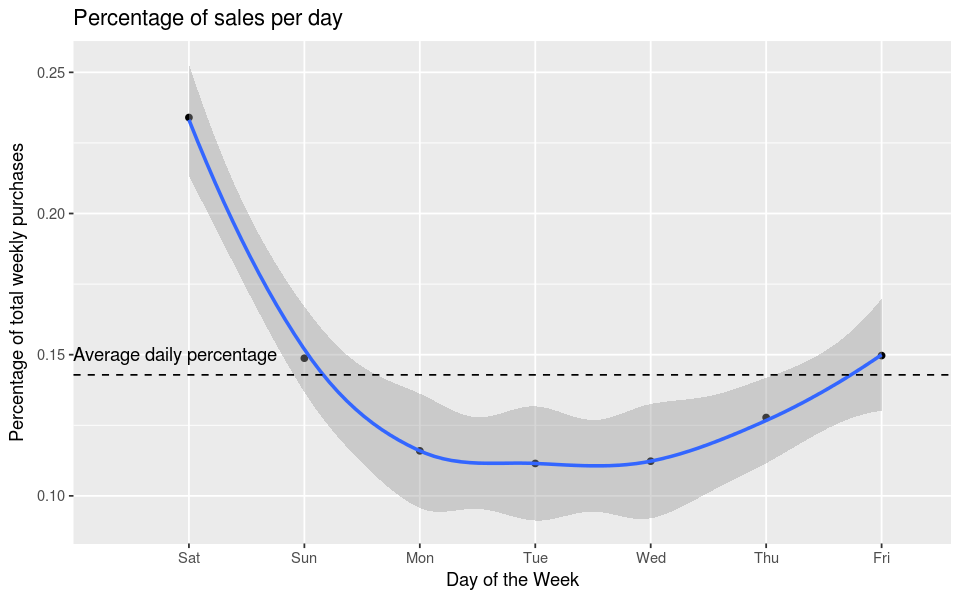

In [7]:
options(repr.plot.width=8, repr.plot.height=5)
orders_by_dow_total <- orders_by_dow %>%
                        group_by(order_dow) %>%
                        summarize(qty = sum(qty))
total = sum(orders_by_dow_total$qty)
avg = mean(orders_by_dow_total$qty/total)
ggplot(orders_by_dow_total, aes(y = qty/total)) + 
geom_point(aes(x = order_dow %>% factor(levels = c(0,1,2,3,4,5,6), 
                                    labels = c("Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"), ordered=TRUE))) +
geom_smooth(method = "loess", aes(x = order_dow+1), level = 0.9) + 
labs(x = "Day of the Week", y = "Percentage of total weekly purchases") +
ggtitle("Percentage of sales per day") +
geom_hline(yintercept = avg,linetype="dashed")+
annotate("text", 0, avg, hjust = 0, vjust = -1, label = "Average daily percentage",)

The following plot shows, for each department (type of product) the percentage of those items that were ordered on each day of the week. 

We can see that for every department (except Alcohol), the trend is similar with higher purchases on the weekend and lower purchases in the middle of the week. However, for Alcohol the highest volume of purchases is done on the days preceding the weekend (Wednesday and Thursday).

We show the trends with an 0.8 confidence interval. We can see that the trend on non-alcoholic products is pretty reliable, as we have multiple data points that follow the same trend.

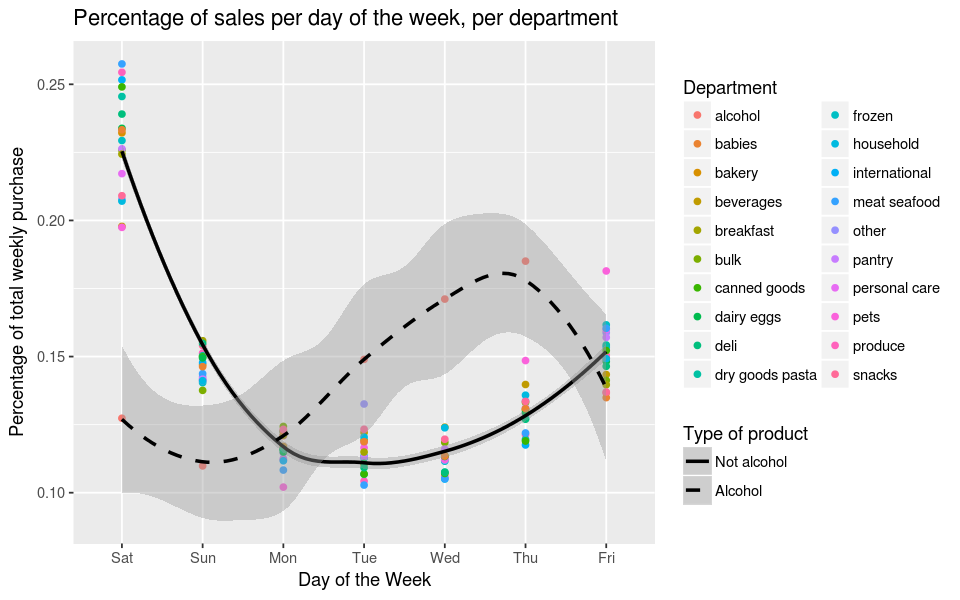

In [8]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(orders_by_dow %>% filter(department_id != 21) , 
       aes(
           y = qty/qty_tot, 
           )) + 
geom_point(aes(color = department,x = order_dow %>% factor(levels = c(0,1,2,3,4,5,6), 
                                    labels = c("Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"), ordered=TRUE),
              group = factor(department == "alcohol", 
                                  levels = c(FALSE,TRUE), 
                                  labels=c("Not alcohol", "Alcohol")))) +
geom_smooth(method = "loess", aes(x = order_dow+1, 
                linetype = factor(department == "alcohol", 
                                  levels = c(FALSE,TRUE), 
                                  labels=c("Not alcohol", "Alcohol"))), 
            col = "black",
            level = 0.8) + 
labs(x = "Day of the Week", y = "Percentage of total weekly purchase", colour = "Department") +
ggtitle("Percentage of sales per day of the week, per department") +
scale_linetype_manual(name = "Type of product",values = c("solid","dashed"))+
guides(color = guide_legend(ncol=2))

One could think that the dissimilar trends are an artifact of splitting the purchases between Alcohol and Not alcohol. The following plots, which show the trends for each department show that this is not true. All departments except alcohol behave like the general trend observed above.

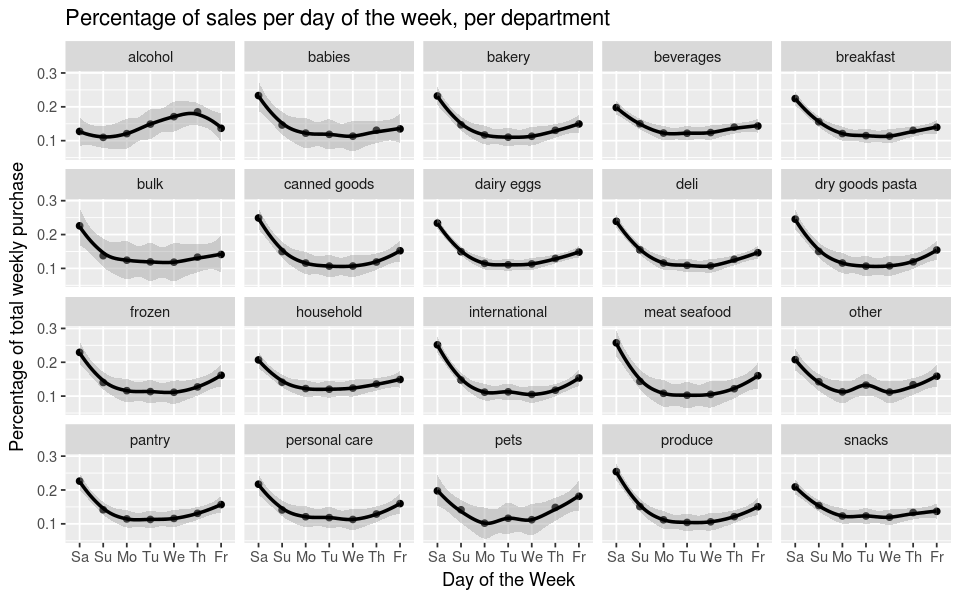

In [9]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(orders_by_dow %>% filter(department_id != 21) , 
       aes(
           y = qty/qty_tot, 
           )) + 
geom_point(aes(x = order_dow %>% factor(levels = c(0,1,2,3,4,5,6), 
                                    labels = c("Sa", "Su", "Mo", "Tu", "We", "Th", "Fr"), ordered=TRUE))) +
facet_wrap(~department)+
geom_smooth(method = "loess", aes(x = order_dow+1), 
            col = "black",
            level = 0.9) + 
labs(x = "Day of the Week", y = "Percentage of total weekly purchase", colour = "Department") +
ggtitle("Percentage of sales per day of the week, per department") +
scale_linetype_manual(name = "Type of product",values = c("solid","dashed"))

## Who orders organic products?

We want to study if users consistently order organic products. We will study the distribution of the percentage of orders per user that contain at least one item labeled as organic.

In order to do this, we will consider only the users that have created at least 2 orders in Instacart

In [10]:
users_multiple_orders <- orders %>%
                          group_by(user_id) %>%
                          summarize(qty_orders = max(order_number)) %>%
                          filter(qty_orders > 1)

We collect the products that are labeled as organic and we assign to each order whether it contains at least one organic product. After that, we associate each user with the percentage of their orders that contain at least one organic product.

In [11]:
organic_products <- filter(products, grepl("organic", product_name, ignore.case = TRUE))

In [ ]:
orders_prior_with_organics <- orders_prior %>%
                                mutate(is_organic = product_id %in% organic_products$product_id) %>%
                                group_by(order_id) %>%
                                summarize(has_organics = (sum(is_organic) > 0))

In [ ]:
orders_with_organics <- merge(subset(orders, eval_set == "prior"),orders_prior_with_organics, by="order_id", all.x = TRUE) %>%
                        select(user_id, has_organics)

In [ ]:
organics_order_ratio_per_user <- orders_with_organics %>% 
       filter(user_id %in% users_multiple_orders$user_id) %>%
       group_by(user_id) %>%
       summarize(ratio_organics = mean(has_organics))

The next plot shows the density of users that have different percentages of orders with organic products in them.

We can see that the distribution is bi-modal, with peaks at 0% and 100%. 

*Note: There's no scale in the y axis, as we care about the shape of the density and not the actual values. It should be scaled to integrate up to 1.*

In [ ]:
ggplot( organics_order_ratio_per_user) +
stat_density(aes(x = ratio_organics),fill="red",alpha=0.5) +
labs(x = "Percentage of orders with organic items", y = "Density")+
ggtitle("Density of users according to the percentage of their orders with organic items") +
scale_x_continuous(breaks = c(0,0.25,0.5,0.75,1), labels = c("0%", "25%", "50%", "75%", "100%") )+
scale_y_continuous(breaks = NULL, labels = NULL)

Below we can see a summary of the distribution and the fact that the median is approximately 85%, and at least 25% of the users orders some organic product in each of their orders.

In [ ]:
summary(organics_order_ratio_per_user$ratio_organics)

## Do more sales equal more reorders?

In "3 million Instacart orders open sources", it is concluded that those products that are ordered the most, are also more likely to be reordered. However, this can be an artifact of the fact that they are ordered quite frequently. We study the case of sales and reorders per department. Therefore we want a more quantitative result of this relationship.

For each department we calculate the Spearman's correlation between the number of times an item was ordered and the percentage of times it was reordered.

In [ ]:
products_reordered_and_bought <- orders_prior %>%
                      group_by(product_id) %>%
                      summarize(ordered = n(),avg_reordered = sum(reordered)/n())

In [ ]:
reordered_by_dept <- products %>%
                     select(product_id, department_id) %>%
                     filter(department_id != 21) %>%
                     left_join(products_reordered_and_bought, by = "product_id", all.x = TRUE) %>%
                     select(product_id, department_id, ordered, avg_reordered) %>%
                     merge(departments, by="department_id",all.x = TRUE) %>%
                     mutate(department = factor(department)) #Removes the "missing" department

In [ ]:
# We remove all the NA
data <- reordered_by_dept %>%
        select(department, ordered, avg_reordered) %>%
        filter(!is.na(avg_reordered) & !is.na(ordered))

In [ ]:
models <- by(data, 
             as.factor(data$department), 
             function (x) cor.test(x$ordered, x$avg_reordered,method="spearman",exact = FALSE));

In [ ]:
result <- data.frame(department = names(models), rho = sapply(models,"[[","estimate"), p.value = sapply(models,"[[","p.value"))
rownames(result) <- c()
result

We can see that in all departments, the Spearman correlation is positive (monotonically increasing relationship) and highly significant. In most of them, the p-value is really small indicating great confidence in the fact that there is a monotonic relationship. The highest p-value occurs in the "Bulk" department, which is one of those with the least number of sales.

In [ ]:
reordered_by_dept %>% group_by(department) %>% summarize(qty = sum(ordered,na.rm=TRUE))

# References

* “The Instacart Online Grocery Shopping Dataset 2017”, Accessed from [https://www.instacart.com/datasets/grocery-shopping-2017](https://www.instacart.com/datasets/grocery-shopping-2017) on 10/28/2017
* *Spachtholz, P.*. "Exploratory Analysis - Instacart". Accessed from [https://www.kaggle.com/philippsp/exploratory-analysis-instacart](https://www.kaggle.com/philippsp/exploratory-analysis-instacart) on 10/29/2017. 
* *Stanley, J.*. "3 million Instacart orders open sources" - Accessed from [https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) on 11/13/2017.